In [1]:
#Libraries used
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import warnings

In [2]:
# Ignore warnings
warnings.filterwarnings('ignore')

In [3]:
# Flight data for every SFO domestic passenger Airline from Jan 2010-Dec 2022
file_names = ['Detailed_Statistics_Departures_1.csv',
              'Detailed_Statistics_Departures_2.csv',
              'Detailed_Statistics_Departures_3.csv',
              'Detailed_Statistics_Departures_4.csv',
              'Detailed_Statistics_Departures_5.csv',
              'Detailed_Statistics_Departures_6.csv']

# Initialize an empty dataframe
combined_df = pd.DataFrame()

# Read and concatenate the CSV files
for file in file_names:
    df = pd.read_csv(file)
    combined_df = pd.concat([combined_df, df])

# Reset the index of the combined dataframe
combined_df = combined_df.reset_index(drop=True)

# Drop rows containing NaN values
combined_df = combined_df.dropna()

# Display the combined dataframe and its shape
print(combined_df.head())
print("\nShape of the dataframe:", combined_df.shape)

  Carrier Code Date (MM/DD/YYYY)  Flight Number Tail Number  \
0           UA          1/1/2010            6.0      N508UA   
1           UA          1/1/2010            8.0      N505UA   
2           UA          1/1/2010           10.0      N560UA   
3           UA          1/1/2010           11.0      N847UA   
4           UA          1/1/2010           34.0      N508UA   

  Destination Airport Scheduled departure time Actual departure time  \
0                 JFK                     7:28                  7:28   
1                 JFK                     9:22                  9:17   
2                 JFK                    13:54                 13:54   
3                 PHL                    22:55                 22:52   
4                 JFK                    22:20                 22:19   

   Scheduled elapsed time (Minutes)  Actual elapsed time (Minutes)  \
0                             331.0                          316.0   
1                             347.0             

In [4]:
# Print column names and data types
for column in combined_df.columns:
    print(f"Column: {column}\tData Type: {combined_df[column].dtype}")

Column: Carrier Code	Data Type: object
Column: Date (MM/DD/YYYY)	Data Type: object
Column: Flight Number	Data Type: float64
Column: Tail Number	Data Type: object
Column: Destination Airport	Data Type: object
Column: Scheduled departure time	Data Type: object
Column: Actual departure time	Data Type: object
Column: Scheduled elapsed time (Minutes)	Data Type: float64
Column: Actual elapsed time (Minutes)	Data Type: float64
Column: Departure delay (Minutes)	Data Type: float64
Column: Wheels-off time	Data Type: object
Column: Taxi-Out time (Minutes)	Data Type: float64
Column: Delay Carrier (Minutes)	Data Type: float64
Column: Delay Weather (Minutes)	Data Type: float64
Column: Delay National Aviation System (Minutes)	Data Type: float64
Column: Delay Security (Minutes)	Data Type: float64
Column: Delay Late Aircraft Arrival (Minutes)	Data Type: float64


In [5]:
# List of columns to delete
columns_to_delete = ['Flight Number', 'Tail Number', 'Actual departure time',
                     'Scheduled elapsed time (Minutes)', 'Actual elapsed time (Minutes)',
                     'Wheels-off time', 'Taxi-Out time (Minutes)', 'Delay Carrier (Minutes)', 'Delay Weather (Minutes)',
                     'Delay National Aviation System (Minutes)', 'Delay Security (Minutes)',
                     'Delay Late Aircraft Arrival (Minutes)']

# Delete the specified columns
combined_df = combined_df.drop(columns=columns_to_delete)

# Display the modified dataframe
print(combined_df.head())
print("\nShape of the dataframe:", combined_df.shape)

  Carrier Code Date (MM/DD/YYYY) Destination Airport Scheduled departure time  \
0           UA          1/1/2010                 JFK                     7:28   
1           UA          1/1/2010                 JFK                     9:22   
2           UA          1/1/2010                 JFK                    13:54   
3           UA          1/1/2010                 PHL                    22:55   
4           UA          1/1/2010                 JFK                    22:20   

   Departure delay (Minutes)  
0                        0.0  
1                       -5.0  
2                        0.0  
3                       -3.0  
4                       -1.0  

Shape of the dataframe: (1242813, 5)


In [6]:
# Extract month and day of the week from the "Date (MM/DD/YYYY)" column
combined_df['Date (MM/DD/YYYY)'] = pd.to_datetime(combined_df['Date (MM/DD/YYYY)'])
combined_df['Month'] = combined_df['Date (MM/DD/YYYY)'].dt.month
combined_df['Day of Week'] = combined_df['Date (MM/DD/YYYY)'].dt.dayofweek

# Filter out flights before 2019 (Done due to hardware restrictions)
combined_df['Year'] = combined_df['Date (MM/DD/YYYY)'].dt.year
combined_df = combined_df[combined_df['Year'] >= 2019]

# Delete the 'Year' and 'Date (MM/DD/YYYY)' column
combined_df = combined_df.drop('Year', axis=1)
combined_df = combined_df.drop('Date (MM/DD/YYYY)', axis=1)

# Display the modified dataframe
print(combined_df.head())
print("\nShape of the dataframe:", combined_df.shape)

     Carrier Code Destination Airport Scheduled departure time  \
1135           UA                 TPA                    21:30   
1136           UA                 LAX                    15:00   
1137           UA                 EWR                    16:00   
1138           UA                 ORD                    22:45   
1139           UA                 LAX                    16:00   

      Departure delay (Minutes)  Month  Day of Week  
1135                       19.0      1            1  
1136                       -5.0      1            1  
1137                       -2.0      1            1  
1138                       18.0      1            1  
1139                       -5.0      1            1  

Shape of the dataframe: (347440, 6)


In [7]:
# Convert "Scheduled departure time" column to minutes as an integer
combined_df['Scheduled departure time'] = pd.to_datetime(combined_df['Scheduled departure time']).dt.hour * 60 + pd.to_datetime(combined_df['Scheduled departure time']).dt.minute

# Display the modified dataframe
print(combined_df.head())
print("\nShape of the dataframe:", combined_df.shape)

     Carrier Code Destination Airport  Scheduled departure time  \
1135           UA                 TPA                      1290   
1136           UA                 LAX                       900   
1137           UA                 EWR                       960   
1138           UA                 ORD                      1365   
1139           UA                 LAX                       960   

      Departure delay (Minutes)  Month  Day of Week  
1135                       19.0      1            1  
1136                       -5.0      1            1  
1137                       -2.0      1            1  
1138                       18.0      1            1  
1139                       -5.0      1            1  

Shape of the dataframe: (347440, 6)


In [8]:
# Add bool target variable 'Is Delayed'
combined_df['Is Delayed'] = combined_df['Departure delay (Minutes)'] >= 15.0
combined_df = combined_df.drop('Departure delay (Minutes)', axis=1)
combined_df['Is Delayed'] = combined_df['Is Delayed'].astype(int)

# Display the modified dataframe
print(combined_df.head())
print("\nShape of the dataframe:", combined_df.shape)

     Carrier Code Destination Airport  Scheduled departure time  Month  \
1135           UA                 TPA                      1290      1   
1136           UA                 LAX                       900      1   
1137           UA                 EWR                       960      1   
1138           UA                 ORD                      1365      1   
1139           UA                 LAX                       960      1   

      Day of Week  Is Delayed  
1135            1           1  
1136            1           0  
1137            1           0  
1138            1           1  
1139            1           0  

Shape of the dataframe: (347440, 6)


In [9]:
# Perform one-hot encoding for categorical columns
categorical_columns = ['Carrier Code', 'Destination Airport', 'Month', 'Day of Week']
ohe = OneHotEncoder(sparse=False)
ohe_results = ohe.fit_transform(combined_df[categorical_columns])
ohe_df = pd.DataFrame(ohe_results, columns=ohe.get_feature_names_out(categorical_columns))
combined_df = pd.concat([combined_df, ohe_df], axis=1)
combined_df = combined_df.drop(combined_df[categorical_columns], axis = 1)

# Display the modified dataframe
print(combined_df.head())
print("\nShape of the dataframe:", combined_df.shape)

      Scheduled departure time  Is Delayed  Carrier Code_AA  Carrier Code_AS  \
1135                    1290.0         1.0              0.0              0.0   
1136                     900.0         0.0              0.0              0.0   
1137                     960.0         0.0              0.0              0.0   
1138                    1365.0         1.0              0.0              0.0   
1139                     960.0         0.0              0.0              0.0   

      Carrier Code_B6  Carrier Code_DL  Carrier Code_UA  Carrier Code_WN  \
1135              0.0              0.0              1.0              0.0   
1136              0.0              0.0              1.0              0.0   
1137              0.0              0.0              1.0              0.0   
1138              0.0              0.0              1.0              0.0   
1139              0.0              0.0              1.0              0.0   

      Destination Airport_ABQ  Destination Airport_ANC  ...  M

In [10]:
# Print every column name and its data type
for column in combined_df.columns:
    print(f"Column: {column}\tData Type: {combined_df[column].dtypes}")

Column: Scheduled departure time	Data Type: float64
Column: Is Delayed	Data Type: float64
Column: Carrier Code_AA	Data Type: float64
Column: Carrier Code_AS	Data Type: float64
Column: Carrier Code_B6	Data Type: float64
Column: Carrier Code_DL	Data Type: float64
Column: Carrier Code_UA	Data Type: float64
Column: Carrier Code_WN	Data Type: float64
Column: Destination Airport_ABQ	Data Type: float64
Column: Destination Airport_ANC	Data Type: float64
Column: Destination Airport_ATL	Data Type: float64
Column: Destination Airport_AUS	Data Type: float64
Column: Destination Airport_BDL	Data Type: float64
Column: Destination Airport_BHM	Data Type: float64
Column: Destination Airport_BNA	Data Type: float64
Column: Destination Airport_BOI	Data Type: float64
Column: Destination Airport_BOS	Data Type: float64
Column: Destination Airport_BUR	Data Type: float64
Column: Destination Airport_BWI	Data Type: float64
Column: Destination Airport_BZN	Data Type: float64
Column: Destination Airport_CLE	Data Typ

In [11]:
# Check for any missing values
print(combined_df.isnull().sum())

# Drop rows with any missing values
combined_df = combined_df.dropna()
print(combined_df.isnull().sum())

Scheduled departure time    256636
Is Delayed                  256636
Carrier Code_AA             256636
Carrier Code_AS             256636
Carrier Code_B6             256636
                             ...  
Day of Week_2               256636
Day of Week_3               256636
Day of Week_4               256636
Day of Week_5               256636
Day of Week_6               256636
Length: 101, dtype: int64
Scheduled departure time    0
Is Delayed                  0
Carrier Code_AA             0
Carrier Code_AS             0
Carrier Code_B6             0
                           ..
Day of Week_2               0
Day of Week_3               0
Day of Week_4               0
Day of Week_5               0
Day of Week_6               0
Length: 101, dtype: int64


In [12]:
# Define features and target
features = combined_df.drop(['Is Delayed'], axis=1)
target = combined_df['Is Delayed']

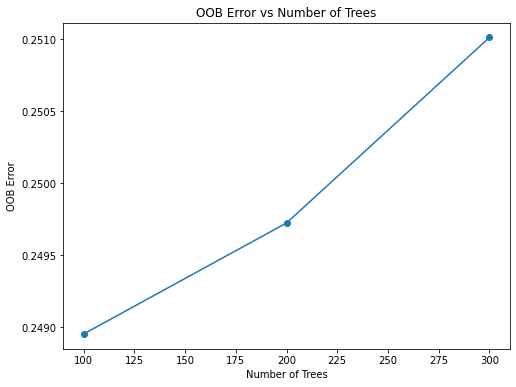

In [13]:
# Train a Random Forest Classifier with different numbers of trees
trees = range(100, 301, 100)
oob_errors = []

for n_trees in trees:
    rf_classifier = RandomForestClassifier(n_estimators=n_trees, oob_score=True, random_state=42)
    rf_classifier.fit(features, target)
    
    # Calculate out-of-bag (OOB) error
    oob_error = 1 - rf_classifier.oob_score_
    oob_errors.append(oob_error)

# Plot OOB error vs number of trees
plt.figure(figsize=(8, 6))
plt.plot(trees, oob_errors, marker='o')
plt.xlabel("Number of Trees")
plt.ylabel("OOB Error")
plt.title("OOB Error vs Number of Trees")
plt.show()

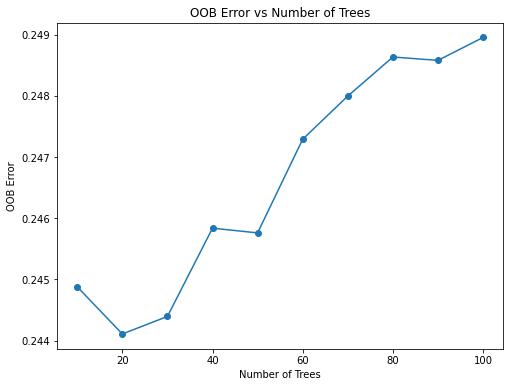

In [14]:
# Train a Random Forest Classifier with different numbers of trees
trees = range(10, 101, 10)
oob_errors = []

for n_trees in trees:
    rf_classifier = RandomForestClassifier(n_estimators=n_trees, oob_score=True, random_state=42)
    rf_classifier.fit(features, target)
    
    # Calculate out-of-bag (OOB) error
    oob_error = 1 - rf_classifier.oob_score_
    oob_errors.append(oob_error)

# Plot OOB error vs number of trees
plt.figure(figsize=(8, 6))
plt.plot(trees, oob_errors, marker='o')
plt.xlabel("Number of Trees")
plt.ylabel("OOB Error")
plt.title("OOB Error vs Number of Trees")
plt.show()

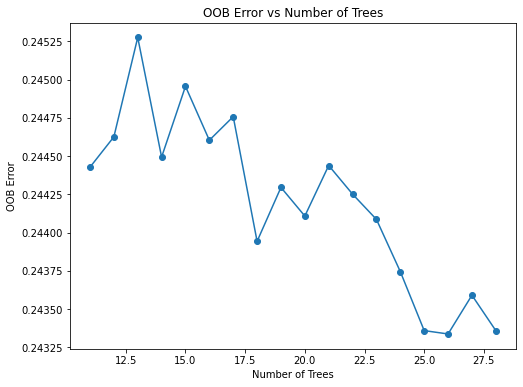

In [15]:
# Train a Random Forest Classifier with different numbers of trees
trees = range(11, 29, 1)
oob_errors = []

for n_trees in trees:
    rf_classifier = RandomForestClassifier(n_estimators=n_trees, oob_score=True, random_state=42)
    rf_classifier.fit(features, target)
    
    # Calculate out-of-bag (OOB) error
    oob_error = 1 - rf_classifier.oob_score_
    oob_errors.append(oob_error)

# Plot OOB error vs number of trees
plt.figure(figsize=(8, 6))
plt.plot(trees, oob_errors, marker='o')
plt.xlabel("Number of Trees")
plt.ylabel("OOB Error")
plt.title("OOB Error vs Number of Trees")
plt.show()

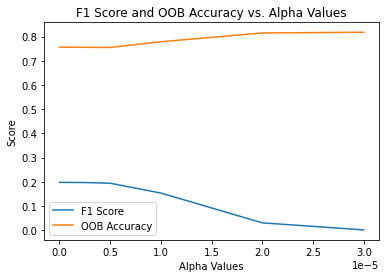

In [16]:
# Range of ccp_alpha values to test
ccp_alphas = [0.0, 0.0000012, 0.0000025, 0.000005, 0.00001, 0.00002, 0.00003]

# Initialize lists to store OOB accuracies, F1 scores, and alpha values
oob_accuracies = []
f1_scores = []
alpha_values = []

# Iterate over different ccp_alpha values
for alpha in ccp_alphas:
    # Create a random forest classifier with 26 trees and the current ccp_alpha value
    rf_classifier = RandomForestClassifier(n_estimators=26, random_state=42, ccp_alpha=alpha, oob_score=True)
    
    # Fit the classifier on the data
    rf_classifier.fit(features, target)
    
    # Obtain the OOB predictions
    oob_predictions = rf_classifier.oob_decision_function_

    # Convert the OOB predictions to discrete class labels
    oob_predictions = [int(prediction[1] >= 0.5) for prediction in oob_predictions]
    
    # Calculate the OOB F1 score
    oob_f1 = f1_score(target, oob_predictions)
    
    # Calculate the OOB accuracy
    oob_accuracy = rf_classifier.oob_score_
    
    # Append the values to the lists
    oob_accuracies.append(oob_accuracy)
    f1_scores.append(oob_f1)
    alpha_values.append(alpha)

# Plot the F1 scores and OOB accuracies
plt.plot(alpha_values, f1_scores, label='F1 Score')
plt.plot(alpha_values, oob_accuracies, label='OOB Accuracy')
plt.xlabel('Alpha Values')
plt.ylabel('Score')
plt.legend()
plt.title('F1 Score and OOB Accuracy vs. Alpha Values')
plt.show()

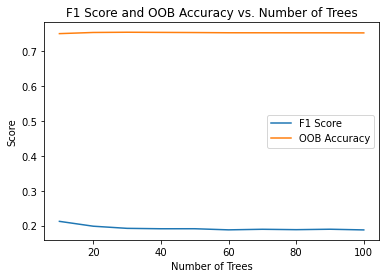

In [17]:
# Train a Random Forest Classifier with different numbers of trees
trees = range(10, 101, 10)

# Initialize lists to store OOB accuracies
oob_accuracies = []
f1_scores = []

# Train and evaluate the random forest for different tree values
for n_trees in trees:
    # Create a random forest classifier with the specified number of trees and ccp_alpha
    rf_classifier = RandomForestClassifier(n_estimators=n_trees, random_state=42, ccp_alpha=0.000005, oob_score=True)
    
    # Fit the classifier on the data
    rf_classifier.fit(features, target)
    
    # Obtain the OOB predictions
    oob_predictions = rf_classifier.oob_decision_function_

    # Convert the OOB predictions to discrete class labels
    oob_predictions = [int(prediction[1] >= 0.5) for prediction in oob_predictions]

    # Calculate the OOB F1 score
    oob_f1 = f1_score(target, oob_predictions)
    
    # Calculate the OOB accuracy
    oob_accuracy = rf_classifier.oob_score_
    
    # Append the values to the lists
    oob_accuracies.append(oob_accuracy)
    f1_scores.append(oob_f1)

# Plot the OOB accuracy as a function of the number of trees
plt.plot(trees, f1_scores, label='F1 Score')
plt.plot(trees, oob_accuracies, label='OOB Accuracy')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.legend()
plt.title('F1 Score and OOB Accuracy vs. Number of Trees')
plt.show()

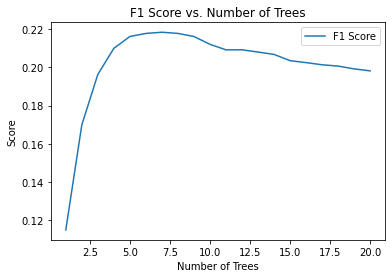

In [18]:
# Train a Random Forest Classifier with different numbers of trees
trees = range(1, 21, 1)

# Initialize lists to store OOB accuracies
oob_accuracies = []
f1_scores = []

# Train and evaluate the random forest for different tree values
for n_trees in trees:
    # Create a random forest classifier with the specified number of trees and ccp_alpha
    rf_classifier = RandomForestClassifier(n_estimators=n_trees, random_state=42, ccp_alpha=0.000005, oob_score=True)
    
    # Fit the classifier on the data
    rf_classifier.fit(features, target)
    
    # Obtain the OOB predictions
    oob_predictions = rf_classifier.oob_decision_function_

    # Convert the OOB predictions to discrete class labels
    oob_predictions = [int(prediction[1] >= 0.5) for prediction in oob_predictions]
    
    # Calculate the OOB F1 score
    oob_f1 = f1_score(target, oob_predictions)
    
    # Calculate the OOB accuracy
    oob_accuracy = rf_classifier.oob_score_
    
    # Append the values to the lists
    oob_accuracies.append(oob_accuracy)
    f1_scores.append(oob_f1)

# Plot the OOB accuracy as a function of the number of trees
plt.plot(trees, f1_scores, label='F1 Score')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.legend()
plt.title('F1 Score vs. Number of Trees')
plt.show()

In [19]:
f1_scores

[0.11471568892493465,
 0.16984542738038147,
 0.19637223974763407,
 0.21006605265606101,
 0.21628152847001963,
 0.21788413098236775,
 0.21851070244196563,
 0.21789550781250003,
 0.21626126682306454,
 0.2121763119944824,
 0.2092659408027076,
 0.2092895290500081,
 0.20812049770792404,
 0.2068668104163211,
 0.2035892123115998,
 0.20256410256410257,
 0.2014246947082768,
 0.20073664825046042,
 0.19925186176601806,
 0.19823986194995685]

In [20]:
#Final Model
# Create a random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=7, random_state=42, ccp_alpha=0.000005, oob_score=True)
    
# Fit the classifier on the data
rf_classifier.fit(features, target)

# Obtain the OOB predictions
oob_predictions = rf_classifier.oob_decision_function_

# Convert the OOB predictions to discrete class labels
oob_predictions = [int(prediction[1] >= 0.5) for prediction in oob_predictions]

# Calculate the OOB F1 score
oob_f1 = f1_score(target, oob_predictions)

# Calculate the OOB accuracy
oob_accuracy = rf_classifier.oob_score_

# Create the confusion matrix
confusion = confusion_matrix(target, oob_predictions)

print("Confusion: ")
print(confusion)
print("F1 score: ", oob_f1)
print("Accuracy: ", oob_accuracy)

Confusion: 
[[61258 13044]
 [12878  3624]]
F1 score:  0.21851070244196563
Accuracy:  0.7506717765737192
